In [63]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Connect to SQL database
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
# Inspect database
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [4]:
# Get a list of column names and types for measurements table
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
date VARCHAR(255)
prcp FLOAT
tobs INTEGER


In [5]:
# Get a list of column names and types for stations table
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(0, 'USC00519397', '2010-01-01', 0.08, 65),
 (1, 'USC00519397', '2010-01-02', 0.0, 63),
 (2, 'USC00519397', '2010-01-03', 0.0, 74),
 (3, 'USC00519397', '2010-01-04', 0.0, 76),
 (4, 'USC00519397', '2010-01-06', 0.0, 73)]

In [7]:
# Reflect the tables into classes and save a reference to those classes called Station and Measurement
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [8]:
session = Session(engine)

# Precipitation Analysis

In [9]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [10]:
# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [97]:
# Date 12 months ago
last_twelve_months = dt.date.today() - relativedelta(months=12)
last_twelve_months

datetime.date(2017, 6, 30)

In [98]:
# Retrieve the last 12 months of precipitation data
p_results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_twelve_months).\
                    group_by(Measurement.date).all()
p_results

[('2017-06-30', 0.07428571428571429),
 ('2017-07-01', 0.065),
 ('2017-07-02', 0.144),
 ('2017-07-03', 0.10571428571428572),
 ('2017-07-04', 0.037500000000000006),
 ('2017-07-05', 0.0),
 ('2017-07-06', 0.0033333333333333335),
 ('2017-07-07', 0.07142857142857142),
 ('2017-07-08', 0.016666666666666666),
 ('2017-07-09', 0.03333333333333333),
 ('2017-07-10', 0.005714285714285714),
 ('2017-07-11', 0.004285714285714286),
 ('2017-07-12', 0.051428571428571435),
 ('2017-07-13', 0.25857142857142856),
 ('2017-07-14', 0.15833333333333335),
 ('2017-07-15', 0.03166666666666667),
 ('2017-07-16', 0.135),
 ('2017-07-17', 0.15166666666666667),
 ('2017-07-18', 0.3614285714285714),
 ('2017-07-19', 0.06833333333333334),
 ('2017-07-20', 0.17714285714285713),
 ('2017-07-21', 0.018571428571428572),
 ('2017-07-22', 0.7366666666666667),
 ('2017-07-23', 0.22600000000000003),
 ('2017-07-24', 0.5449999999999999),
 ('2017-07-25', 0.08714285714285715),
 ('2017-07-26', 0.07142857142857142),
 ('2017-07-27', 0.001428571

In [99]:
# Put data into dataframe
precipitation_df = pd.DataFrame(p_results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df.head()

,Precipitation
Date,
2017-06-30,0.074286
2017-07-01,0.065000
2017-07-02,0.144000
2017-07-03,0.105714
2017-07-04,0.037500


<function matplotlib.pyplot.show>

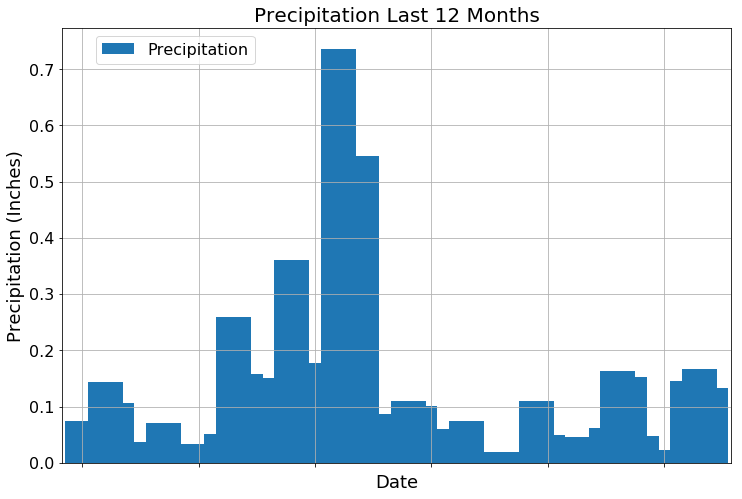

In [100]:
# Plot the precipitation for the past 12 months
ax = precipitation_df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Precipitation Last 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.savefig("Precipitation.png")
plt.show

In [101]:
# Print the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,55.000000
mean,0.094962
std,0.131611
min,0.000000
25%,0.017083
50%,0.060000
75%,0.133750
max,0.736667


# Station Analysis

In [102]:
# Calculate the total number of stations
session.query(Station.id).count()

9

In [103]:
# Design a query to find the most active stations.
# List the stations and observation counts in descending order
# Which station has the highest number of observations? - USC00519281 with 2772 observations
s_results = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
s_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [104]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
best_station = s_results[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()

[(54, 71.66378066378067, 85)]

In [105]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
t_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == best_station).\
                filter(Measurement.date >= last_twelve_months).all()
tobs_df = pd.DataFrame(t_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,76
USC00519281,79
USC00519281,81
USC00519281,76
USC00519281,78


<function matplotlib.pyplot.show>

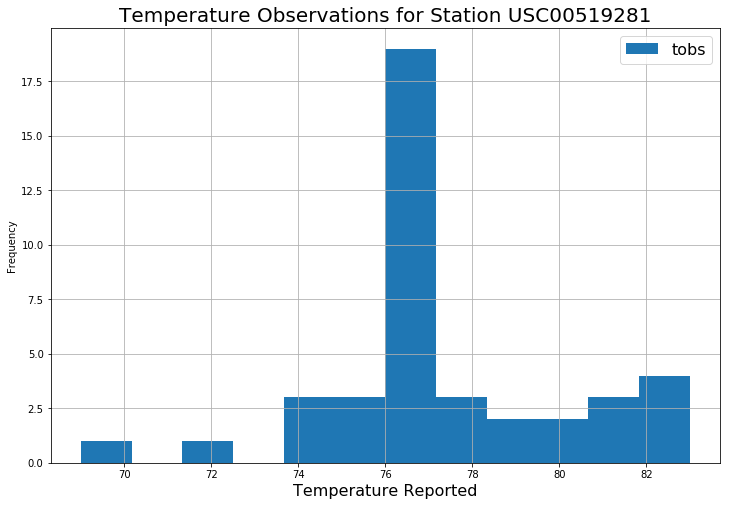

In [106]:
# Plot the results as a histogram with bins=12.
tobs_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Station " + best_station, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.show

# Temperature Analysis

In [107]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
# and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
    c_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
    return c_results
calc_temps('2017-01-01', '2017-12-31')

[(58, 74.14387974230493, 87)]

In [108]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2017-07-02', '2017-07-08')
trip_results

[(71, 78.11904761904762, 87)]

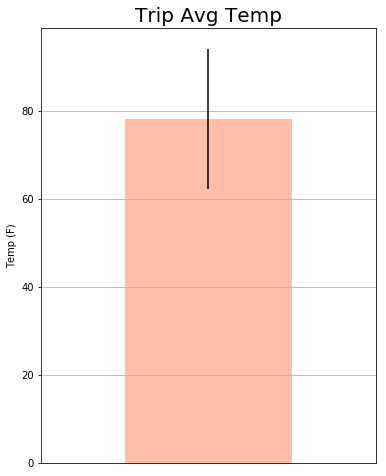

In [110]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()